Goal: To predict the author of a given long-form text by training a logistic regression classifier on real samples of writing from multiple authors including the user's own SOPs. The model learns stylistic and lexical patterns associated with each author and is later used to determine whether a new, unseen SOP (**generated by a fine-tuned Metallama model**) aligns with the user's personal writing style.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split

In [ ]:
#mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

#file path
file_path = "/content/drive/MyDrive/llamatest/cleaned_authorship_dataset.csv"

In [ ]:
!ls "/content/drive/MyDrive/llamatest"

cleaned_authorship_dataset.csv	dataset_with_prompts.xlsx


In [ ]:
# Load the dataset
df = pd.read_csv(file_path)

# Display first few rows
df.head()

id                                       cleaned_text
0  10.0  Tim/Bob:\nAttached is the letter that we sent ...
1  10.0  May-June, 2000\n---------------------- AM ----...
2  10.0  mona.petrochko@enron.com, susan.mara@enron.com...
3  10.0  james.steffes@enron.com, richard.shapiro@enron...
4  10.0  sarah.novosel@enron.com, susan.mara@enron.com,...

In [ ]:
import pandas as pd

#file path
file_path_2 = "/content/drive/MyDrive/llamatest/dataset_with_prompts.xlsx"

# Load the dataset
merged_df = pd.read_excel(file_path_2)

# Display first few rows
merged_df.head()

cleaned_text  \
0  STATEMENT OF PURPOSE The future belongs to tho...   
1  STATEMENT OF PURPOSE Ambition is infinite; thi...   
2  STATEMENT OF PURPOSE Today, technology has the...   
3  STATEMENT OF PURPOSE In this contemporary era,...   
4  STATEMENT OF PURPOSE Do it yourself and do it ...   

                                                text  
0  Prompt: Generate a long-form academic Statemen...  
1  Prompt: Generate a long-form academic Statemen...  
2  Prompt: Generate a long-form academic Statemen...  
3  Prompt: Generate a long-form academic Statemen...  
4  Prompt: Generate a long-form academic Statemen...

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52134 entries, 0 to 52133
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            52134 non-null  float64
 1   cleaned_text  52134 non-null  object 
dtypes: float64(1), object(1)
memory usage: 814.7+ KB


In [ ]:

# Check missing values
print("Missing values before cleaning:\n", df.isnull().sum())

# Drop rows where cleaned_text is missing
df = df.dropna(subset=["cleaned_text"])

# Check again after dropping missing cleaned_text
print("Missing values after removing empty text rows:\n", df.isnull().sum())

# Fill missing IDs with a placeholder (if necessary)
#df["id"] = df["id"].fillna(-1)  # Use -1 to indicate unknown author

# Save cleaned dataset
df.to_csv("cleaned_authorship_dataset.csv", index=False)

print("Final dataset shape:", df.shape)
df.head()


Missing values before cleaning:
 id              0
cleaned_text    0
dtype: int64
Missing values after removing empty text rows:
 id              0
cleaned_text    0
dtype: int64
Final dataset shape: (52134, 2)


id                                       cleaned_text
0  10.0  Tim/Bob:\nAttached is the letter that we sent ...
1  10.0  May-June, 2000\n---------------------- AM ----...
2  10.0  mona.petrochko@enron.com, susan.mara@enron.com...
3  10.0  james.steffes@enron.com, richard.shapiro@enron...
4  10.0  sarah.novosel@enron.com, susan.mara@enron.com,...

In [ ]:
# Number of unique authors
print(f"Total Unique Authors: {df['id'].nunique()}")

# Distribution of samples per author
author_counts = df['id'].value_counts()

# Show top 10 authors with most data
print("\nTop 10 Authors by Sample Count:\n", author_counts.head(10))

# Visualize author distribution
plt.figure(figsize=(8,4))
sns.histplot(author_counts, bins=20, kde=True)
plt.xlabel("Number of Samples per Author")
plt.ylabel("Frequency")
plt.title("Distribution of Text Samples per Author")
plt.show()

Total Unique Authors: 7

Top 10 Authors by Sample Count:
 id
11.0        16716
12.0        14206
10.0        11356
449628.0     4217
734562.0     2293
589736.0     2288
123456.0     1058
Name: count, dtype: int64


## 📊 Dataset Overview and Distribution Analysis


###  Author Distribution
- The dataset is **highly imbalanced** across authors.
- The most represented author (`id = 11.0`) contributes **16,716 samples**.
- The least represented author (`id = 123456.0`, corresponding to **Model 1's training author**) has only **1,058 samples**.
- Other authors have between **2,288 and 14,206 samples**, highlighting a skewed dataset.

### Distribution of Text Samples per Author
- The histogram shows a **right-skewed distribution**.
- A **few authors dominate** the dataset, contributing the bulk of the samples.
- This imbalance can introduce **bias** and cause the model to **overfit to dominant authors**.

---

## Implications for Model 2 Development

To improve generalization and reduce author bias:

- **Downsampling** the majority classes may help balance representation.
- **Data augmentation** (e.g., using synthetic generation) could enhance minority author representation.
- **Stratified sampling** is essential for fair training/validation splits.

###Top Authors by Sample Count:



1.   Author 11.0 has the most samples (16,716), followed by 12.0 (14,206), and 10.0 (11,356).
2.   Other authors have significantly fewer samples (e.g., 123456.0 has only 1,058). This imbalance could affect training




In [ ]:
# Convert all 'id' values to string type
df = df.dropna(subset=["id"])
df["id"] = df["id"].astype(str)

# Verify the change
print(df.dtypes)  # id should now be 'object' (string)
df.head(5)

id              object
cleaned_text    object
dtype: object


id                                       cleaned_text
0  10.0  Tim/Bob:\nAttached is the letter that we sent ...
1  10.0  May-June, 2000\n---------------------- AM ----...
2  10.0  mona.petrochko@enron.com, susan.mara@enron.com...
3  10.0  james.steffes@enron.com, richard.shapiro@enron...
4  10.0  sarah.novosel@enron.com, susan.mara@enron.com,...

In [ ]:
#drop the records of author 123456
df = df[df["id"] != "123456.0"]

In [ ]:
#check if successfully dropped
df['id'].value_counts()

id
11.0        16716
12.0        14206
10.0        11356
449628.0     4217
734562.0     2293
589736.0     2288
Name: count, dtype: int64

In [ ]:
import pandas as pd

# STEP 1: Add word and character counts
df["word_count"] = df["cleaned_text"].apply(lambda x: len(str(x).split()))
df["char_count"] = df["cleaned_text"].apply(lambda x: len(str(x)))

# STEP 2: Filter for short-form content (quote-like)
df_long = df[(df["word_count"] >= 300) & (df["char_count"] >= 1000)]

df_long.head()


id                                       cleaned_text  word_count  \
2  10.0  mona.petrochko@enron.com, susan.mara@enron.com...        2057   
3  10.0  james.steffes@enron.com, richard.shapiro@enron...         659   
4  10.0  sarah.novosel@enron.com, susan.mara@enron.com,...        1229   
7  10.0  mona.petrochko@enron.com, susan.mara@enron.com...        2057   
8  10.0  sarah.novosel@enron.com, susan.mara@enron.com,...        1229   

   char_count  
2       13394  
3        5501  
4        8023  
7       13394  
8        8023

In [ ]:
# STEP 3: Cap each author to 400 entries max
df_balanced = df_long.groupby("id", group_keys=False).apply(lambda x: x.sample(min(len(x), 350), random_state=42))

# STEP 4: Reset index for cleanliness
df_balanced = df_balanced.reset_index(drop=True)

# Preview
df_balanced['id'].value_counts()
df_balanced.head()


<ipython-input-14-4247547e114d>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df_long.groupby("id", group_keys=False).apply(lambda x: x.sample(min(len(x), 350), random_state=42))


id                                       cleaned_text  word_count  \
0  10.0  User s\n----- \n\tJBennett <JBennett@GMSSR.com...         394   
1  10.0  rent "true grit."  very cool. I highly recomme...         561   
2  10.0  jdasovic@enron.com, leslie.lawner@enron.com, m...         402   
3  10.0  sandra.mccubbin@enron.com, susan.mara@enron.co...        1122   
4  10.0  This mean we'll be toning down our criticism o...         479   

   char_count  
0        6021  
1        3643  
2        3133  
3        7351  
4        3093

In [ ]:
#check unique entries per author
df_balanced['id'].value_counts()

id
10.0        350
11.0        350
12.0        350
449628.0    148
589736.0     99
734562.0     99
Name: count, dtype: int64

## Integrating User Sops into the Authorship Dataset

1. **Load Personal Style Data**  
   - Load `merged_df.csv`, which contains user long form text.
   - Extract the `cleaned_text` column, ensuring only non-null, unique entries are included.

2. **Label and Format User Data**
   - Wrap them in a new DataFrame.
   - Assign an author label `"user"` to all entries.
   - Calculate:
     - `word_count` – number of words
     - `char_count` – number of characters

3. **Apply Long-Form Filter**
   - Keep only those with more than:
     - > 300 words
     - >1000 characters  
   This ensures consistency with the format of long-form texts in the original dataset.

4. **Concatenate with Balanced Dataset**
   - Combine long form text (`df_user_sops`) with the already balanced dataset (`df_balanced`) using `pd.concat`.

5. **Verify Class Distribution**
   - Print value counts of the `id` column to confirm that the `"user"` class has been successfully added.

### Why This Matters

Adding your sops allows the model to:
- Learn and compare your writing style
- Be evaluated fairly against existing authors in downstream tasks like classification or generation

In [ ]:

# Load your personal SOPs from merged_df.csv
user_sops_df = pd.read_excel("/content/drive/MyDrive/llamatest/dataset_with_prompts.xlsx")

# Extract cleaned SOPs
user_cleaned_sops = user_sops_df["cleaned_text"].dropna().unique()

# Wrap them in a new DataFrame and label them as 'user'
df_user_sops = pd.DataFrame({
    "cleaned_text": user_cleaned_sops,
    "id": ["user"] * len(user_cleaned_sops)
})

# Optional: Apply same long-form filtering for consistency
df_user_sops["word_count"] = df_user_sops["cleaned_text"].apply(lambda x: len(str(x).split()))
df_user_sops["char_count"] = df_user_sops["cleaned_text"].apply(lambda x: len(str(x)))

df_user_sops = df_user_sops[(df_user_sops["word_count"] >= 300) & (df_user_sops["char_count"] >= 1000)]

# Finalize format to match df_balanced
df_user_sops = df_user_sops[["id", "cleaned_text"]]

# Concatenate with the balanced dataset
df_final = pd.concat([df_balanced, df_user_sops], ignore_index=True)

# Check updated class distribution
df_final["id"].value_counts()


id
user        443
11.0        350
10.0        350
12.0        350
449628.0    148
589736.0     99
734562.0     99
Name: count, dtype: int64

Average Word Count: 758.63
Average Character Count: 4956.87


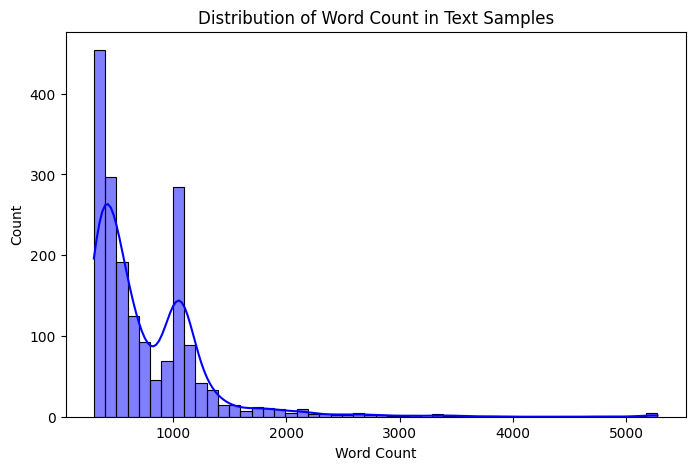

In [ ]:
# Add text length features
df_final["word_count"] = df_final["cleaned_text"].apply(lambda x: len(str(x).split()))
df_final["char_count"] = df_final["cleaned_text"].apply(lambda x: len(str(x)))

# Display basic text statistics
print(f"Average Word Count: {df_final['word_count'].mean():.2f}")
print(f"Average Character Count: {df_final['char_count'].mean():.2f}")

# Plot word count distribution
plt.figure(figsize=(8,5))
sns.histplot(df_final["word_count"], bins=50, kde=True, color="blue")
plt.xlabel("Word Count")
plt.title("Distribution of Word Count in Text Samples")
plt.show()

In [ ]:
df_final = df_final[df_final['word_count'] <= 2000]

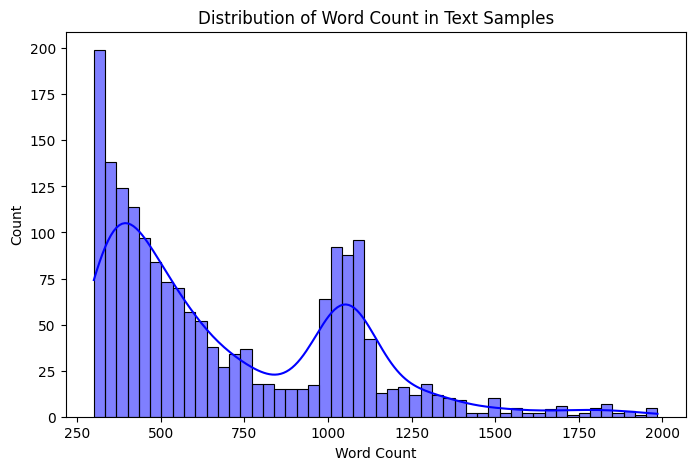

In [ ]:
# Plot word count distribution
plt.figure(figsize=(8,5))
sns.histplot(df_final["word_count"], bins=50, kde=True, color="blue")
plt.xlabel("Word Count")
plt.title("Distribution of Word Count in Text Samples")
plt.show()

In [ ]:
df_final.head()

id                                       cleaned_text  word_count  \
0  10.0  User s\n----- \n\tJBennett <JBennett@GMSSR.com...         394   
1  10.0  rent "true grit."  very cool. I highly recomme...         561   
2  10.0  jdasovic@enron.com, leslie.lawner@enron.com, m...         402   
3  10.0  sandra.mccubbin@enron.com, susan.mara@enron.co...        1122   
4  10.0  This mean we'll be toning down our criticism o...         479   

   char_count  
0        6021  
1        3643  
2        3133  
3        7351  
4        3093

In [ ]:
#counting unique number of words
def dim():
  dimensions=len(set(df_final['cleaned_text'].str.split().explode().values))
  print(f'{dimensions} dimensions in the potential DFM.')

dim()

84626 dimensions in the potential DFM.


In [ ]:
#covert everything to lower case
df_final['cleaned_text'] = df_final['cleaned_text'].str.lower()

This step ensures text normalization by converting all words to lowercase.


In [ ]:
#remove stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words=stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df_final['cleaned_text_nostop'] = df_final['cleaned_text'].apply(lambda x: ' ()'.join([word for word in x.split() if word not in (stop_words)]))
df_final.head()

id                                       cleaned_text  word_count  \
0  10.0  user s\n----- \n\tjbennett <jbennett@gmssr.com...         394   
1  10.0  rent "true grit."  very cool. i highly recomme...         561   
2  10.0  jdasovic@enron.com, leslie.lawner@enron.com, m...         402   
3  10.0  sandra.mccubbin@enron.com, susan.mara@enron.co...        1122   
4  10.0  this mean we'll be toning down our criticism o...         479   

   char_count                                cleaned_text_nostop  
0        6021  user ()----- ()jbennett ()<jbennett@gmssr.com>...  
1        3643  rent ()"true ()grit." ()cool. ()highly ()recom...  
2        3133  jdasovic@enron.com, ()leslie.lawner@enron.com,...  
3        7351  sandra.mccubbin@enron.com, ()susan.mara@enron....  
4        3093  mean ()toning ()criticism ()utility's ()behavi...

In [ ]:
dim()

75613 dimensions in the potential DFM.


In [ ]:
#remove punctuation
import string
df_final['cleaned_text_nopunct'] = df_final['cleaned_text_nostop'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
df_final.head()

id                                       cleaned_text  word_count  \
0  10.0  user s\n----- \n\tjbennett <jbennett@gmssr.com...         394   
1  10.0  rent "true grit."  very cool. i highly recomme...         561   
2  10.0  jdasovic@enron.com, leslie.lawner@enron.com, m...         402   
3  10.0  sandra.mccubbin@enron.com, susan.mara@enron.co...        1122   
4  10.0  this mean we'll be toning down our criticism o...         479   

   char_count                                cleaned_text_nostop  \
0        6021  user ()----- ()jbennett ()<jbennett@gmssr.com>...   
1        3643  rent ()"true ()grit." ()cool. ()highly ()recom...   
2        3133  jdasovic@enron.com, ()leslie.lawner@enron.com,...   
3        7351  sandra.mccubbin@enron.com, ()susan.mara@enron....   
4        3093  mean ()toning ()criticism ()utility's ()behavi...   

                                cleaned_text_nopunct  
0  user  jbennett jbennettgmssrcom 04142001 0939 ...  
1  rent true grit cool highly recommendfrom great...  
2  jdasovicenroncom leslielawnerenroncom mdaygmss...  
3  sandramccubbinenroncom susanmaraenroncom karen...  
4  mean toning criticism utilitys behavior califo...

In [ ]:
from nltk.stem import PorterStemmer
ps=PorterStemmer()

df_final['cleaned_text_stemmed'] = df_final['cleaned_text_nopunct'].apply(lambda x: ' '.join([ps.stem(word) for word in x.split()]))
df_final.head()

id                                       cleaned_text  word_count  \
0  10.0  user s\n----- \n\tjbennett <jbennett@gmssr.com...         394   
1  10.0  rent "true grit."  very cool. i highly recomme...         561   
2  10.0  jdasovic@enron.com, leslie.lawner@enron.com, m...         402   
3  10.0  sandra.mccubbin@enron.com, susan.mara@enron.co...        1122   
4  10.0  this mean we'll be toning down our criticism o...         479   

   char_count                                cleaned_text_nostop  \
0        6021  user ()----- ()jbennett ()<jbennett@gmssr.com>...   
1        3643  rent ()"true ()grit." ()cool. ()highly ()recom...   
2        3133  jdasovic@enron.com, ()leslie.lawner@enron.com,...   
3        7351  sandra.mccubbin@enron.com, ()susan.mara@enron....   
4        3093  mean ()toning ()criticism ()utility's ()behavi...   

                                cleaned_text_nopunct  \
0  user  jbennett jbennettgmssrcom 04142001 0939 ...   
1  rent true grit cool highly recommendfrom great...   
2  jdasovicenroncom leslielawnerenroncom mdaygmss...   
3  sandramccubbinenroncom susanmaraenroncom karen...   
4  mean toning criticism utilitys behavior califo...   

                                cleaned_text_stemmed  
0  user jbennett jbennettgmssrcom 04142001 0939 d...  
1  rent true grit cool highli recommendfrom great...  
2  jdasovicenroncom leslielawnerenroncom mdaygmss...  
3  sandramccubbinenroncom susanmaraenroncom karen...  
4  mean tone critic util behavior california mark...

In [ ]:
doc_complete = df_final['cleaned_text_stemmed']
doc_complete

0       user jbennett jbennettgmssrcom 04142001 0939 d...
1       rent true grit cool highli recommendfrom great...
2       jdasovicenroncom leslielawnerenroncom mdaygmss...
3       sandramccubbinenroncom susanmaraenroncom karen...
4       mean tone critic util behavior california mark...
                              ...                        
1834    statement purpos comput scienc alway inspir co...
1835    statement purpos would like introduc sreya v a...
1836    statement purpos bigger opportun greater scope...
1837    statement purpos enthusiast technolog student ...
1838    statement purpos world expand rampantli indust...
Name: cleaned_text_stemmed, Length: 1790, dtype: object

In [ ]:
!pip install textstat

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.3/105.3 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 939.4/939.4 kB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 54.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import string
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from textstat import flesch_reading_ease, smog_index
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

##Lexical, Syntactic & TF-IDF Feature Extraction

###Lexical & Syntactic Features
A custom function was defined to extract key linguistic characteristics from each text:

- **Average Sentence Length**: Number of words per sentence.
- **Vocabulary Richness**: Unique words divided by total words.
- **Punctuation Count**: Number of punctuation characters in the text.

These features help capture writing complexity, variation, and stylistic habits.

After applying the function to each sample (`cleaned_text_stemmed`), the results were merged into the original dataset (`df_final` → `balanced_df`).

---

###TF-IDF Vectorization
To capture meaningful word usage across authors, TF-IDF was used:

- **TF-IDF Vectorizer**: Fitted on `cleaned_text_stemmed` column.
- **Stopwords Removed**: English stopwords excluded.
- **Top 50 Features**: Only the 50 most informative terms were retained.
- The resulting matrix was converted into a DataFrame for inspection and modeling.

This creates a compact, interpretable representation of word importance — useful for author identification or stylistic clustering.

In [ ]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
# Function to compute lexical and syntactic features
def lexical_syntactic_analysis(text):
    if not isinstance(text, str) or len(text.strip()) == 0:
        return {"avg_sentence_length": 0, "vocabulary_richness": 0, "punctuation_count": 0}

    words = word_tokenize(text)
    sentences = sent_tokenize(text)
    word_count = len(words)
    sentence_count = len(sentences)
    unique_words = len(set(words))
    punctuation_count = sum(1 for char in text if char in string.punctuation)

    return {
        "avg_sentence_length": word_count / sentence_count if sentence_count > 0 else 0,
        "vocabulary_richness": unique_words / word_count if word_count > 0 else 0,
        "punctuation_count": punctuation_count
    }


# Apply lexical and syntactic analysis to the dataset
lexical_features = df_final["cleaned_text_stemmed"].apply(lexical_syntactic_analysis)

# Convert dictionary results to DataFrame and merge with original data
lexical_features_df = pd.DataFrame(lexical_features.tolist())

# Concatenate lexical features with original DataFrame
balanced_df = pd.concat([df_final, lexical_features_df], axis=1)


In [ ]:
# TF-IDF Analysis
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=50)
balanced_df['cleaned_text_stemmed'] = balanced_df['cleaned_text_stemmed'].fillna('')
tfidf_matrix = tfidf_vectorizer.fit_transform(balanced_df["cleaned_text_stemmed"])
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

# Convert TF-IDF results to DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_feature_names)
tfidf_df.head()

20  agreement      busi  colleg   compani    comput  data   develop  \
0  0.000000        0.0  0.000000     0.0  0.550000  0.000000   0.0  0.000000   
1  0.000000        0.0  0.290167     0.0  0.000000  0.000000   0.0  0.276501   
2  0.000000        0.0  0.000000     0.0  0.000000  0.000000   0.0  0.000000   
3  0.032466        0.0  0.024400     0.0  0.024439  0.030012   0.0  0.000000   
4  0.000000        0.0  0.000000     0.0  0.000000  0.000000   0.0  0.173237   

      email    energi  ...  studi  technolog     think      time  understand  \
0  0.000000  0.604814  ...    0.0        0.0  0.000000  0.000000         0.0   
1  0.151020  0.000000  ...    0.0        0.0  0.064849  0.201675         0.0   
2  0.000000  0.000000  ...    0.0        0.0  0.000000  0.000000         0.0   
3  0.025399  0.188126  ...    0.0        0.0  0.043626  0.016959         0.0   
4  0.000000  0.200238  ...    0.0        0.0  0.162520  0.126356         0.0   

   univers       use      want      work      year  
0      0.0  0.000000  0.000000  0.000000  0.000000  
1      0.0  0.115285  0.060038  0.052371  0.000000  
2      0.0  0.000000  0.197282  0.000000  0.197019  
3      0.0  0.000000  0.060583  0.000000  0.060503  
4      0.0  0.144460  0.300925  0.000000  0.150262  

[5 rows x 50 columns]

In [ ]:
corpus=[doc.split() for doc in doc_complete]

corpus

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1790 entries, 0 to 1838
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    1790 non-null   object
 1   cleaned_text          1790 non-null   object
 2   word_count            1790 non-null   int64 
 3   char_count            1790 non-null   int64 
 4   cleaned_text_nostop   1790 non-null   object
 5   cleaned_text_nopunct  1790 non-null   object
 6   cleaned_text_stemmed  1790 non-null   object
dtypes: int64(2), object(5)
memory usage: 176.4+ KB


##Preparing Data for Classification

In this step, we define the input features and target labels for training an author classification model.

- **`X`** contains the stemmed version of each text (`cleaned_text_stemmed`) — this will be used as input to the model.
- **`y`** contains the corresponding author IDs, converted to string format for compatibility with classification algorithms.

This setup is essential before applying vectorization (e.g., TF-IDF) and fitting a classifier like Logistic Regression.

In [ ]:
# Final cleanup- drop any rows where id is NaN or 'nan' string before training
balanced_df = balanced_df[balanced_df['id'].notna()]
balanced_df = balanced_df[balanced_df['id'] != 'nan']  # remove string 'nan'
balanced_df["id"] = balanced_df["id"].astype(str)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define X and y
X = balanced_df["cleaned_text_stemmed"]
y = balanced_df["id"].astype(str)



In [ ]:
print(X)

0       user jbennett jbennettgmssrcom 04142001 0939 d...
1       rent true grit cool highli recommendfrom great...
2       jdasovicenroncom leslielawnerenroncom mdaygmss...
3       sandramccubbinenroncom susanmaraenroncom karen...
4       mean tone critic util behavior california mark...
                              ...                        
1834    statement purpos comput scienc alway inspir co...
1835    statement purpos would like introduc sreya v a...
1836    statement purpos bigger opportun greater scope...
1837    statement purpos enthusiast technolog student ...
1838    statement purpos world expand rampantli indust...
Name: cleaned_text_stemmed, Length: 1790, dtype: object


##Step 2: TF-IDF Vectorization

To convert raw text into numerical features for model training, we use **TF-IDF (Term Frequency-Inverse Document Frequency)**:

- **`TfidfVectorizer`** transforms the text into a matrix of TF-IDF features.
- **`stop_words='english'`** removes common English stop words to reduce noise.
- **`max_features=1000`** limits the vocabulary to the top 1000 most informative words.

This results in a feature matrix `X_vec` that can now be used for training classification models.

In [ ]:
# Step 2: Vectorize
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X_vec = tfidf_vectorizer.fit_transform(X)



In [ ]:
# Step 3: Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=0.2, random_state=42, stratify=y)



In [ ]:
print("Unique labels in training:", sorted(y_train.unique()))

Unique labels in training: ['10.0', '11.0', '12.0', '449628.0', '589736.0', '734562.0', 'user']


##Model Training and Evaluation (Steps 4–6)

###Model Summary for Authorship Classification (Logistic Regression)

**Model Architecture:**
- **TF-IDF Vectorizer:** Converts text into a sparse matrix of weighted token frequencies (`max_features=1000`).
- **Logistic Regression:** A linear classifier trained to distinguish between authors based on these features.
  - Each class (author ID) gets its own set of weights.
  - The model outputs probabilities via the softmax function.

**Loss Function:**
- **Cross-Entropy Loss:** Measures the difference between predicted probabilities and true author labels.
  - Penalizes the model more when it confidently predicts the wrong author.


###Step 4: Train Logistic Regression
- A **Logistic Regression** model is initialized and trained using the training data (`X_train`, `y_train`).
- `max_iter=1000` ensures the model has enough iterations to converge.
- `random_state=42` ensures reproducibility.

###Step 5: Make Predictions
- The model generates predictions (`y_pred`) on the unseen test set (`X_test`).

###Step 6: Evaluate Performance
- **`classification_report`** displays key performance metrics:
  - **Precision**, **Recall**, **F1-score** per author class (label)
  - **Overall accuracy**

This provides insights into how well the model distinguishes between different authors based on their writing style.


In [ ]:
# Step 4: Train Logistic Regression
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)



LogisticRegression(max_iter=1000, random_state=42)

In [ ]:
# Step 5: Predict on test set
y_pred = model.predict(X_test)



In [ ]:
# Step 6: Evaluate
print("Classification Report:\n")
print(classification_report(y_test, y_pred))



Classification Report:

              precision    recall  f1-score   support

        10.0       0.94      0.94      0.94        67
        11.0       0.96      0.91      0.93        70
        12.0       0.94      0.94      0.94        69
    449628.0       0.73      1.00      0.85        30
    589736.0       0.00      0.00      0.00        19
    734562.0       0.00      0.00      0.00        19
        user       0.99      1.00      0.99        84

    accuracy                           0.85       358
   macro avg       0.65      0.69      0.67       358
weighted avg       0.84      0.85      0.84       358



### Key Observations:
Labels 10.0, 11.0, 12.0 and user perform consistently well showing balanced and accurate predictions.

Label 449628.0 shows perfect recall (1.00) but low precision (0.73) hence captured all relevant samples but also falsely predicted others as this class.

Labels 589736.0 and 734562.0 have 0.00 across all metrics — the model completely failed to predict these correctly likely due to the low samples.


## Confusion Matrix Interpretation

The confusion matrix shows how well the logistic regression model predicts author identities based on text samples.

- **Rows** represent the actual authors.
- **Columns** represent the predicted authors.
- **Diagonal values** indicate correct predictions.
- **Off-diagonal values** show misclassifications.

Classes 10.0, 11.0, 12.0, and user have high accuracy.

Class 449628.0 has perfect recall and precision.

Class 589736.0 is often misclassified, mostly into class 734562.0 and 449628.0.

Class 734562.0 did not perform well, with no correct predictions, it is mostly confused with class 589736.0.

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Example: assuming 'model' is trained and you already have test data (X_test, y_test)
# Make sure y_test is the true author names (string labels)
y_scores = model.predict_proba(X_test)  # shape: [n_samples, n_classes]
y_true = y_test  # list or array of author names (e.g., ['manasa', 'other', 'other', ...])

# Convert string labels to one-hot encoding
classes = model.classes_  # e.g., ['manasa', 'other']
y_bin = label_binarize(y_true, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i, class_label in enumerate(classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(8, 6))
for i, class_label in enumerate(classes):
    plt.plot(fpr[i], tpr[i], label=f"Class '{class_label}' (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random Baseline')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Author Classification (Model 2)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

The classifier accurately predicts our writing style.

##Evaluating Model 1's Authorship Style Using Logistic Regression



In [ ]:
import zipfile
import os
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string

# STEP 1: Unzip the outputs.zip file
zip_path = "/content/outputs.zip"
extract_folder = "/content/outputs"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

# STEP 2: Preprocessing (same as training)
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess(text):
    text = text.lower()
    text = ' '.join([word for word in text.split() if word not in stop_words])
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ' '.join([stemmer.stem(word) for word in text.split()])
    return text

# STEP 3: Read and preprocess .txt files
generated_sops = []
file_names = []

for filename in os.listdir(extract_folder):
    if filename.endswith(".txt"):
        file_path = os.path.join(extract_folder, filename)
        with open(file_path, "r", encoding="utf-8") as file:
            content = file.read()
            preprocessed = preprocess(content)
            generated_sops.append(preprocessed)
            file_names.append(filename)

# STEP 4: Vectorize with trained TF-IDF
X_gen = tfidf_vectorizer.transform(generated_sops)

# STEP 5: Predict with trained model
preds = model.predict(X_gen)
probs = model.predict_proba(X_gen)

# STEP 6: Output results
print("\nPrediction Results:\n")
for i, name in enumerate(file_names):
    predicted_author = preds[i]
    confidence = probs[i][model.classes_.tolist().index(predicted_author)]
    match = "Yes" if str(predicted_author) == "user" else "No"

    print(f"Filename          : {name}")
    print(f"Predicted Author  : {predicted_author}")
    print(f"Is Your Style     : {match}")
    print(f"Confidence        : {confidence:.2%}")
    print("-" * 50)



Prediction Results:

Filename          : sop_custom_20250412_185103.txt
Predicted Author  : user
Is Your Style     : Yes
Confidence        : 88.80%
--------------------------------------------------
Filename          : sop_custom_20250412_185717.txt
Predicted Author  : user
Is Your Style     : Yes
Confidence        : 83.04%
--------------------------------------------------
Filename          : sop_custom_20250412_182750.txt
Predicted Author  : user
Is Your Style     : Yes
Confidence        : 56.59%
--------------------------------------------------
Filename          : sop_custom_20250412_165614.txt
Predicted Author  : user
Is Your Style     : Yes
Confidence        : 60.74%
--------------------------------------------------
Filename          : sop_custom_20250412_160402.txt
Predicted Author  : user
Is Your Style     : Yes
Confidence        : 70.91%
--------------------------------------------------


The authorship classification model, trained on the dataset of the user's SOPs and semi-formal long-form texts, predicted all Metallama generated SOPs as being authored by the user. Confidence scores ranged from 56.59% to 88.80%, indicating generally strong stylistic alignment, though with slightly more variability than TinyLLaMA. While TinyLLaMA outputs scored more consistently above 88%, Metallama wider range reflects its enhanced generative diversity and richer expression, which sometimes extended stylistically into the domain of non-user samples. Overall, the results reaffirm that Metallama effectively captures the author’s tone while offering greater narrative depth.

In [ ]:
import zipfile
import os
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string

# STEP 1: Unzip the outputs.zip file
zip_path = "/content/outputs.zip"
extract_folder = "/content/outputs"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

# STEP 2: Preprocessing (same as training)
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess(text):
    text = text.lower()
    text = ' '.join([word for word in text.split() if word not in stop_words])
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ' '.join([stemmer.stem(word) for word in text.split()])
    return text

# STEP 3: Read and preprocess .txt files
generated_sops = []
file_names = []

for filename in os.listdir(extract_folder):
    if filename.endswith(".txt"):
        file_path = os.path.join(extract_folder, filename)
        with open(file_path, "r", encoding="utf-8") as file:
            content = file.read()
            preprocessed = preprocess(content)
            generated_sops.append(preprocessed)
            file_names.append(filename)

# STEP 4: Vectorize with trained TF-IDF
X_gen = tfidf_vectorizer.transform(generated_sops)

# STEP 5: Predict with trained model
preds = model.predict(X_gen)
probs = model.predict_proba(X_gen)

# STEP 6: Output results
print("\nPrediction Results:\n")
for i, name in enumerate(file_names):
    predicted_author = preds[i]
    confidence = probs[i][model.classes_.tolist().index(predicted_author)]
    match = "Yes" if str(predicted_author) == "user" else "No"

    print(f"Filename          : {name}")
    print(f"Predicted Author  : {predicted_author}")
    print(f"Is Your Style     : {match}")
    print(f"Confidence        : {confidence:.2%}")
    print("-" * 50)
